# Homework 8 - Artificial Neural Networks with PyTorch

## About 

### In this homework, you will get your feet wet with deep learning using the PyTorch deep learning platform. This will involve:
* Preparing data 
* Learning about the components of a deep learning pipeline
* Setting up a model, a loss function, and an optimizer
* Setting up training and testing loops
* Using a visualizer like tensorboard to monitor logged data

*This homework is due __April 15th 2019__. Training neural networks takes some time, particularly on CPUs so start early.* 


## Dev Environment
### Working on Google Colab
You may choose to work locally or on Google Colaboratory. You have access to free compute through this service. 
1. Visit https://colab.research.google.com/drive 
2. Navigate to the **`Upload`** tab, and upload your `HW8.ipynb`
3. Now on the top right corner, under the `Comment` and `Share` options, you should see a `Connect` option. Once you are connected, you will have access to a VM with 12GB RAM, 50 GB disk space and a single GPU. The dropdown menu will allow you to connect to a local runtime as well.

**Notes:** 
* **If you do not have a working setup for Python 3, this is your best bet. It will also save you from heavy installations like `tensorflow` if you don't want to deal with those.**
* ***There is a downside*. You can only use this instance for a single 12-hour stretch, after which your data will be deleted, and you would have redownload all your datasets, any libraries not already on the VM, and regenerate your logs**.


### Installing PyTorch and Dependencies

The instructions for installing and setting up PyTorch can be found at https://pytorch.org/get-started/locally/. Make sure you follow the instructions for your machine. For any of the remaining libraries used in this assignment:
* We have provided a `hw8_requirements.txt` file on the homework web page. 
* Download this file, and in the same directory you can run `pip3 install -r hw8_requirements.txt`

Check that PyTorch installed correctly by running the following:

In [1]:
import torch
torch.rand(5, 3)

tensor([[0.2814, 0.5178, 0.9002],
        [0.6943, 0.0311, 0.6966],
        [0.2842, 0.0950, 0.4123],
        [0.7685, 0.2156, 0.5545],
        [0.3900, 0.3036, 0.7561]])

The output should look something like

```python
tensor([[0.3380, 0.3845, 0.3217],
        [0.8337, 0.9050, 0.2650],
        [0.2979, 0.7141, 0.9069],
        [0.1449, 0.1132, 0.1375],
        [0.4675, 0.3947, 0.1426]])
```

### Let's get started with the assignment.

## Instructions
### Part 1 -  Datasets and Dataloaders (10 points)

In this section we will download the MNIST dataset using PyTorch's own API.

Helpful Resources:
* https://pytorch.org/docs/stable/torchvision/datasets.html#mnist
* https://pytorch.org/docs/stable/torchvision/transforms.html
* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html


The `torchvision` package consists of popular datasets, model architectures, and common image transformations for computer vision. We are particularly concerned with `torchvision.datasets` and `torchvision.transforms`. Check out the API for these modules in the links provided above.

**Create a directory named `hw8_data` with the following command**.

In [2]:
!mkdir hw8_data


**Now use `torch.datasets.MNIST` to load the Train and Test data into `hw8_data`.** 
* ** Use the directory you created above as the `root` directory for your datasets**
* ** Populate the `transformations` variable with any transformations you would like to perform on your data.** (Hint: You will need to do at least one)
* **Pass your `transformations` variable to `torch.datasets.MNIST`. This allows you to perform arbitrary transformations to your data at loading time.**

In [3]:
from torchvision import datasets, transforms

## YOUR CODE HERE ##
transformations = transforms.Compose([
    transforms.CenterCrop(10),
    transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./hw8_data', train=True, download=True, transform=transformations) 
mnist_test = datasets.MNIST(root='./hw8_data', train=False, download=True, transform=transformations) 

  0%|          | 0.00/9.91M [00:00<?, ?B/s]

9.92MB [00:02, 3.37MB/s]                            


Extracting ./hw8_data/MNIST/raw/train-images-idx3-ubyte.gz


32.8kB [00:00, 273kB/s]                            
0.00B [00:00, ?B/s]

Extracting ./hw8_data/MNIST/raw/train-labels-idx1-ubyte.gz


1.65MB [00:00, 2.64MB/s]                           
8.19kB [00:00, 108kB/s]


Extracting ./hw8_data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./hw8_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Check that your torch datasets have been successfully downloaded into your data directory by running the next two cells. 

* Each will output some metadata about your dataset. 
* Check that the training set has 60000 datapoints and a `Root Location: hw8_data`
* Check that the testing (__also validation in our case__) set has 10000 datapoints and `Root Location: hw8_data`

Notice that these datasets implement the python `__len__` and `__getitem__` functions. Each element in the dataset should be a 2-tuple. What does yours look like?

In [4]:
print(len(mnist_train))
print(len(mnist_train[0]))
mnist_train

60000
2


Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./hw8_data
    Transforms (if any): Compose(
                             CenterCrop(size=(10, 10))
                             ToTensor()
                         )
    Target Transforms (if any): None

In [5]:
print(len(mnist_test))
print(len(mnist_test[0]))
mnist_test

10000
2


Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./hw8_data
    Transforms (if any): Compose(
                             CenterCrop(size=(10, 10))
                             ToTensor()
                         )
    Target Transforms (if any): None

**Any file in our dataset will now be read at runtime, and the specified transformations we need on it will be applied when we need it.**. 

We could iterate through these directly using a loop, but this is not idiomatic. PyTorch provides us with this abstraction in the form of `DataLoaders`. The module of interest is `torch.utils.data.DataLoader`. 

`DataLoader` allows us to do lots of useful things
* Group our data into batches
* Shuffle our data
* Load the data in parallel using `multiprocessing` workers

**Use `DataLoader` to create a loader for the training set and one for the testing set**
* **Use a `batch_size` of 32 to start, you may change it if you wish.**
* **Set the `shuffle` parameter to `True`.** 


In [48]:
from torch.utils.data import DataLoader

## YOUR CODE HERE ##
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=32, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                           batch_size=32, 
                                           shuffle=True)

The following function is adapted from `show_landmarks_batch` at 
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#iterating-through-the-dataset . 

Run the following cell to see that your loader provides a random `batch_size` number of data points.

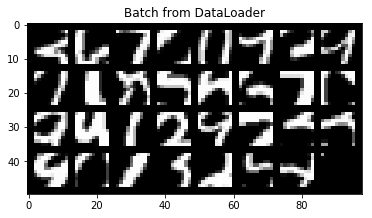

In [49]:
import matplotlib.pyplot as plt
from torchvision import utils
%matplotlib inline

def show_mnist_batch(sample_batched):
    """Show images for a batch of samples."""
    images_batch = sample_batched[0]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from DataLoader')
    
# Displays the first batch of images
for i, batch in enumerate(train_loader):
    if i==1:
        break
    show_mnist_batch(batch)

### Part 2  - Models, Loss Functions and Optimizers (10 points)

In this section, we will do the following:
* Learn about how to build your deep learning model and define its parameters
* Choose a loss function to optimize
* Choose an optimization method to maximize/minimize the loss

We'll first start with a single layer neural network to do handwritten digit classification. The math may ring some bells from homework 7.

`torch.nn` is the module we will be using here. You can find the API at https://pytorch.org/docs/stable/nn.html. There is also a quick summary at https://pytorch.org/tutorials/beginner/nn_tutorial.html#closing_thoughts.

#### Models

We will use the following python modules in building our one layer model.

* `torch.nn.Module`: Your model will be abstracted as a python class. Your python class must subclass `torch.nn.Module`. It is the base class for all neural network modules in PyTorch (Do not confuse python modules with PyTorch Modules). These implement the `forward()` function which defines how your model handles input and produces an output. Your model class can also have `torch.nn.Module`s as members, allowing nested tree like structures, and it is leveraging this that you are able to build neural networks in PyTorch.   

* `torch.nn.Linear`: A unit of computation in neural networks are *Layers* and PyTorch provides abstractions for layers as `nn.Modules`. These come in many forms including *Convolutional*, *Recurrent*, and *Linear*. You can find the API for linear layers here https://pytorch.org/docs/stable/nn.html#linear-layers.

**Now use the information provided to define the `OneLayerModel` class below. The superclass constructor has been called for you, and this allows your subclass to access superclass methods and members.**
* **Finish the `__init__()` function.**
* **Finish the `forward()` function.** (Hint: Use that fact that layer modules implement their own `forward()` function)





In [60]:
from torch import nn
class OneLayerModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(OneLayerModel, self).__init__()
        ## YOUR CODE HERE ##
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        ## YOUR CODE HERE ##
        x = x.view(-1, self.input_dim)
        x = self.fc1(x)
        return x

#### Loss Functions and Optimizers

You've defined your model but now what? It's just a black box that takes an input and spits out some numbers. You haven't yet defined what it means to be a good or bad model. 

A ***Loss Function*** takes what your model outputs and compares it to what it *should* have put out. It returns some  meaningful value used to update your model parameters, and so train your model. Check out Section 21.2.1 of the textbook for more details about types of loss functions. The Loss function represents the overall goal of building this model, and the choice of loss function is very important. 

We must examine our model parameters and our problem instance to see about how to choose a loss function.
* We take in a 784-dimensional vector and output 10 real values, giving our model 784 x 10 parameters. 
* It is natural given that our problem is an instance of *multi-class classification* that we would want each of our output values to model `P(y==i|x)`.
* If we go this route, we get an added constraint that the sum of all 10 of our output values should be 1 (forming a probability mass distribution).

Turns out there is a very convenient loss function for just our use case known as ***cross-entropy loss***. Check out this reference https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy for a little more intuition on this.

Once again, PyTorch has abstractions built in for us in the `torch.nn` module, namely `torch.nn.CrossEntropyLoss`. The API can be found at https://pytorch.org/docs/stable/nn.html#crossentropyloss. 

We're still not ready to train our model because while we have some parameters, and we have some measure of how good or bad our predictions are, we have no notion of how to go about updating our parameters in order to improve our loss. 

This is where ***Optimizers*** come in. In general, we have one main way of minimizing loss functions (training our models), and that is through *Stochastic Gradient Descent* https://en.wikipedia.org/wiki/Stochastic_gradient_descent. There are many variants and optimizations of this method, however, and the `torch.optim` package gives us abstractions for these. The API can be found at https://pytorch.org/docs/stable/optim.html#.

In [17]:
from torch import optim

### Part 3 - Training and Validation (45 points)

In this section we will learn how to use the concepts we've learned about so far to train the model we built, and validate how well it does.We also want to monitor how well our training is going while it is happening. 

For this we can use a package called `tensorboardX`. You will need to install this package using `pip` or `Anaconda`, based on your dev environment. Additionally, we'll want to use a logging module called `tensorboardX.SummaryWriter`. You can consult the API here https://tensorboardx.readthedocs.io/en/latest/tutorial.html. Run the next cell to ensure that all is working well.

In [61]:
""" Try uncommenting these commands if you're facing issues here
!pip3 install -U protobuf
!pip3 install -U tensorflow
!pip3 install -U tensorboardX
"""
%load_ext tensorboard.notebook
from tensorboardX import SummaryWriter

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


We have provided the code to use `tensorboard` just before calling your `train` function. You don't have to change the top-level log directory, but you can create multiple runs (different parameters or versions of your code) just by creating subdirectories for these within your top-level directory.

**Now use the information provided above to do the following:**
* ** Instantiate a `OneLayerModel` with the appropriate input/output parameters.**
* ** Define a cross-entropy loss function.**
* ** Define a stochastic gradient descent optimizer based for you model's parameters. Start with a learning rate of 0.001, and adjust as necessary. You can start with the vanilla `optim.SGD` optimizer, and change it if you wish.** 
* **Create a `SummaryWriter` object that will be responsible for logging our training progress into a directory called `logs/expt1` (Or whatever you wish your top-level directory to be called).**

In [62]:
## YOUR CODE HERE ##
model = OneLayerModel(1*10*10, 10)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
momentum = 0.5
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
writer = SummaryWriter('logs/expt1')

We've finally come to the point where we need to write our training set up. We're going to use both our training and testing (validation) sets for this. Note that traditionally, you would separate part of your training data into validation data in order to get an unbiased estimate of how your model performs, but here we'll just pretend that our testing data is our validation data. 

**Training a model with batches of data broadly involves the following steps:**
1. **One `epoch` is defined as a full pass of your dataset through your model. We choose the number of epochs we wish to train our model for.**
2. **In each epoch, set your model to train mode.** 
3. **you feed your model `batch_size` examples at a time, and receive `batch_size` number of outputs until you've gotten through your entire dataset.**
4. **Calculate the loss function for those outputs given the labels for that batch.**
5. **Now calculate the gradients for each model parameter.** (Hint: Your loss function object can do this for you)
6. **Update your model parameters** (Hint: The optimizer comes in here)
7. **Set the gradients in your model to zero for the next batch.**
8. **After each epoch, set your model to evaluation mode.**
9. **Now evaluate your model on the validation data. Log the total loss and accuracy over the validation data.** (Note: PyTorch does automatic gradient calculations in the background through its `Autograd` mechanism https://pytorch.org/docs/stable/notes/autograd.html. Make sure to do evaluation in a context where this is turned off!)

**Complete the `train()` function below. Try to make it as general as possible, so that it can be used for improved versions of you model. Feel free to define as many helper functions as needed.**
**Make sure that you do the following: **
* **Log the *training loss* and *training accuracy* on each batch for every epoch, such that it will show up on `tensorboard`.**
* **Log the loss on the validation set and the accuracy on the validation set every epoch**

**You will need to produce the plots for these.**

You may also want to add some print statements in your training function to report progress in this notebook.

In [75]:

def train(model, train_loader, val_loader, loss_func, optimizer,num_epochs=10, writer=None):
    test(model, val_loader, loss_func, 0)
    for epoch in range(1, num_epochs + 1):
        print(epoch)
        train_internal(model, train_loader, loss_func, optimizer, writer, epoch)
        test(model, val_loader, loss_func, epoch)

        
train_losses = []
train_accuracies = []
log_interval = 10

def train_internal(model, train_loader, loss_func, optimizer, writer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        correct = 0
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        loss_item = loss
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss_item))
            
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
        accuracy = 100. * correct / len(train_loader.dataset)
        train_losses.append(loss_item)
        train_accuracies.append(accuracy)
        
        writer.add_scalar('train_losses',loss_item, batch_idx)
        writer.add_scalar('train_accuracies',accuracy, batch_idx)
            
            
test_losses = []
test_accuracies = []

def test(model, val_loader, loss_func, epoch_num):
    model.eval()
    loss_item = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss_item += loss_func(output, target)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            
    loss_item /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    test_losses.append(loss_item)
    test_accuracies.append(accuracy)
    writer.add_scalar('test_losses',loss_item, epoch_num)
    writer.add_scalar('test_accuracies',accuracy, epoch_num)
    
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    loss_item, correct, len(val_loader.dataset),accuracy))

Finally call `train` with the relevant parameters. Run the tensorboard command on your top-level logs directory to monitor training. If there is logging data from a previous run, just delete the directory for the run, and reinstantiate the `SummaryWriter` for that run. (You may want to reinstantiate the model itself if you want to clear the model parameters too).

Note : This function may take a while to complete if you're training for many epochs on a cpu. This is where it comes in handy to be running on Google Colab, or just have a GPU on hand. 

In [76]:
#%tensorboard --logdir=logs
train(model, train_loader, test_loader, criterion, optimizer, 15, writer)


Test set: Avg. loss: 0.0244, Accuracy: 7621/10000 (76.00%)

1
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.821260
Train Epoch: 1 [320/60000 (1%)]	Loss: 0.874756
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.781158
Train Epoch: 1 [960/60000 (2%)]	Loss: 0.667878
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.923006
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.515299
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.816035
Train Epoch: 1 [2240/60000 (4%)]	Loss: 0.853043
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.777009
Train Epoch: 1 [2880/60000 (5%)]	Loss: 0.636304
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.777671
Train Epoch: 1 [3520/60000 (6%)]	Loss: 0.876890
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.891727
Train Epoch: 1 [4160/60000 (7%)]	Loss: 0.812504
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.906046
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.856025
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.888424
Train Epoch: 1 [5440/60000 (9%)]	Loss: 0.724832
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.090071
Train Epoch: 1 [6080/60000 (10

Train Epoch: 1 [53120/60000 (89%)]	Loss: 0.856144
Train Epoch: 1 [53440/60000 (89%)]	Loss: 0.827310
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.767725
Train Epoch: 1 [54080/60000 (90%)]	Loss: 0.931231
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.844481
Train Epoch: 1 [54720/60000 (91%)]	Loss: 0.804672
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.939591
Train Epoch: 1 [55360/60000 (92%)]	Loss: 0.952095
Train Epoch: 1 [55680/60000 (93%)]	Loss: 0.995283
Train Epoch: 1 [56000/60000 (93%)]	Loss: 0.594267
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.984329
Train Epoch: 1 [56640/60000 (94%)]	Loss: 0.775962
Train Epoch: 1 [56960/60000 (95%)]	Loss: 0.723980
Train Epoch: 1 [57280/60000 (95%)]	Loss: 0.888228
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.814635
Train Epoch: 1 [57920/60000 (97%)]	Loss: 0.699127
Train Epoch: 1 [58240/60000 (97%)]	Loss: 0.792089
Train Epoch: 1 [58560/60000 (98%)]	Loss: 0.581827
Train Epoch: 1 [58880/60000 (98%)]	Loss: 0.562638
Train Epoch: 1 [59200/60000 (99%)]	Loss: 0.807600


Train Epoch: 2 [46400/60000 (77%)]	Loss: 1.036578
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.745691
Train Epoch: 2 [47040/60000 (78%)]	Loss: 0.794539
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.990763
Train Epoch: 2 [47680/60000 (79%)]	Loss: 0.713975
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.596440
Train Epoch: 2 [48320/60000 (81%)]	Loss: 0.672274
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.833459
Train Epoch: 2 [48960/60000 (82%)]	Loss: 0.839975
Train Epoch: 2 [49280/60000 (82%)]	Loss: 1.101486
Train Epoch: 2 [49600/60000 (83%)]	Loss: 0.638536
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.783388
Train Epoch: 2 [50240/60000 (84%)]	Loss: 0.645397
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.472383
Train Epoch: 2 [50880/60000 (85%)]	Loss: 0.825850
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.720232
Train Epoch: 2 [51520/60000 (86%)]	Loss: 0.976114
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.730671
Train Epoch: 2 [52160/60000 (87%)]	Loss: 0.777865
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.822219


Train Epoch: 3 [39040/60000 (65%)]	Loss: 0.599433
Train Epoch: 3 [39360/60000 (66%)]	Loss: 0.635681
Train Epoch: 3 [39680/60000 (66%)]	Loss: 0.677468
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.599597
Train Epoch: 3 [40320/60000 (67%)]	Loss: 1.097150
Train Epoch: 3 [40640/60000 (68%)]	Loss: 0.891496
Train Epoch: 3 [40960/60000 (68%)]	Loss: 1.141981
Train Epoch: 3 [41280/60000 (69%)]	Loss: 0.590290
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.681881
Train Epoch: 3 [41920/60000 (70%)]	Loss: 1.011582
Train Epoch: 3 [42240/60000 (70%)]	Loss: 0.868974
Train Epoch: 3 [42560/60000 (71%)]	Loss: 0.738967
Train Epoch: 3 [42880/60000 (71%)]	Loss: 0.487202
Train Epoch: 3 [43200/60000 (72%)]	Loss: 0.825110
Train Epoch: 3 [43520/60000 (73%)]	Loss: 1.016424
Train Epoch: 3 [43840/60000 (73%)]	Loss: 0.649210
Train Epoch: 3 [44160/60000 (74%)]	Loss: 0.789357
Train Epoch: 3 [44480/60000 (74%)]	Loss: 0.927386
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.878022
Train Epoch: 3 [45120/60000 (75%)]	Loss: 0.935718


Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.905070
Train Epoch: 4 [32960/60000 (55%)]	Loss: 0.626973
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.585507
Train Epoch: 4 [33600/60000 (56%)]	Loss: 0.995458
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.704244
Train Epoch: 4 [34240/60000 (57%)]	Loss: 0.807216
Train Epoch: 4 [34560/60000 (58%)]	Loss: 1.142045
Train Epoch: 4 [34880/60000 (58%)]	Loss: 0.682786
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.839965
Train Epoch: 4 [35520/60000 (59%)]	Loss: 0.910101
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.709568
Train Epoch: 4 [36160/60000 (60%)]	Loss: 0.738227
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.506072
Train Epoch: 4 [36800/60000 (61%)]	Loss: 0.830952
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.701727
Train Epoch: 4 [37440/60000 (62%)]	Loss: 0.865031
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.614951
Train Epoch: 4 [38080/60000 (63%)]	Loss: 1.054103
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.660088
Train Epoch: 4 [38720/60000 (65%)]	Loss: 0.580085


Train Epoch: 5 [24960/60000 (42%)]	Loss: 0.786390
Train Epoch: 5 [25280/60000 (42%)]	Loss: 0.931770
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.692278
Train Epoch: 5 [25920/60000 (43%)]	Loss: 0.949820
Train Epoch: 5 [26240/60000 (44%)]	Loss: 0.570178
Train Epoch: 5 [26560/60000 (44%)]	Loss: 0.524059
Train Epoch: 5 [26880/60000 (45%)]	Loss: 1.081113
Train Epoch: 5 [27200/60000 (45%)]	Loss: 0.835767
Train Epoch: 5 [27520/60000 (46%)]	Loss: 0.879677
Train Epoch: 5 [27840/60000 (46%)]	Loss: 0.798938
Train Epoch: 5 [28160/60000 (47%)]	Loss: 0.763356
Train Epoch: 5 [28480/60000 (47%)]	Loss: 0.771042
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.865352
Train Epoch: 5 [29120/60000 (49%)]	Loss: 0.634030
Train Epoch: 5 [29440/60000 (49%)]	Loss: 0.760148
Train Epoch: 5 [29760/60000 (50%)]	Loss: 0.971506
Train Epoch: 5 [30080/60000 (50%)]	Loss: 1.095227
Train Epoch: 5 [30400/60000 (51%)]	Loss: 0.476563
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.604427
Train Epoch: 5 [31040/60000 (52%)]	Loss: 0.773699


Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.496496
Train Epoch: 6 [18240/60000 (30%)]	Loss: 0.935351
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.993104
Train Epoch: 6 [18880/60000 (31%)]	Loss: 0.572752
Train Epoch: 6 [19200/60000 (32%)]	Loss: 1.072593
Train Epoch: 6 [19520/60000 (33%)]	Loss: 0.740317
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.643172
Train Epoch: 6 [20160/60000 (34%)]	Loss: 0.844328
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.738715
Train Epoch: 6 [20800/60000 (35%)]	Loss: 0.646213
Train Epoch: 6 [21120/60000 (35%)]	Loss: 1.210592
Train Epoch: 6 [21440/60000 (36%)]	Loss: 0.768247
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.517468
Train Epoch: 6 [22080/60000 (37%)]	Loss: 0.670829
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.741784
Train Epoch: 6 [22720/60000 (38%)]	Loss: 0.608840
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.416851
Train Epoch: 6 [23360/60000 (39%)]	Loss: 0.816589
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.602256
Train Epoch: 6 [24000/60000 (40%)]	Loss: 0.762926


Train Epoch: 7 [11200/60000 (19%)]	Loss: 0.979489
Train Epoch: 7 [11520/60000 (19%)]	Loss: 1.150424
Train Epoch: 7 [11840/60000 (20%)]	Loss: 0.591484
Train Epoch: 7 [12160/60000 (20%)]	Loss: 0.823606
Train Epoch: 7 [12480/60000 (21%)]	Loss: 0.772444
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.744602
Train Epoch: 7 [13120/60000 (22%)]	Loss: 0.810440
Train Epoch: 7 [13440/60000 (22%)]	Loss: 0.936108
Train Epoch: 7 [13760/60000 (23%)]	Loss: 0.785371
Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.654537
Train Epoch: 7 [14400/60000 (24%)]	Loss: 1.192785
Train Epoch: 7 [14720/60000 (25%)]	Loss: 0.769605
Train Epoch: 7 [15040/60000 (25%)]	Loss: 1.030210
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.720365
Train Epoch: 7 [15680/60000 (26%)]	Loss: 1.061754
Train Epoch: 7 [16000/60000 (27%)]	Loss: 1.206159
Train Epoch: 7 [16320/60000 (27%)]	Loss: 0.801794
Train Epoch: 7 [16640/60000 (28%)]	Loss: 0.813654
Train Epoch: 7 [16960/60000 (28%)]	Loss: 0.746816
Train Epoch: 7 [17280/60000 (29%)]	Loss: 0.743318


Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.537798
Train Epoch: 8 [4160/60000 (7%)]	Loss: 0.622794
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.595810
Train Epoch: 8 [4800/60000 (8%)]	Loss: 0.803645
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.678643
Train Epoch: 8 [5440/60000 (9%)]	Loss: 0.605968
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.984671
Train Epoch: 8 [6080/60000 (10%)]	Loss: 1.118692
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.617041
Train Epoch: 8 [6720/60000 (11%)]	Loss: 0.606561
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.594136
Train Epoch: 8 [7360/60000 (12%)]	Loss: 0.867533
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.830808
Train Epoch: 8 [8000/60000 (13%)]	Loss: 0.835464
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.934228
Train Epoch: 8 [8640/60000 (14%)]	Loss: 0.749475
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.878550
Train Epoch: 8 [9280/60000 (15%)]	Loss: 0.475957
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.754296
Train Epoch: 8 [9920/60000 (17%)]	Loss: 0.639995
Train Epoch: 8 [10240/6000

Train Epoch: 8 [57600/60000 (96%)]	Loss: 1.335881
Train Epoch: 8 [57920/60000 (97%)]	Loss: 0.756901
Train Epoch: 8 [58240/60000 (97%)]	Loss: 0.515400
Train Epoch: 8 [58560/60000 (98%)]	Loss: 1.082972
Train Epoch: 8 [58880/60000 (98%)]	Loss: 1.156507
Train Epoch: 8 [59200/60000 (99%)]	Loss: 0.660657
Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.765044
Train Epoch: 8 [59840/60000 (100%)]	Loss: 0.763395

Test set: Avg. loss: 0.0233, Accuracy: 7720/10000 (77.00%)

9
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.934299
Train Epoch: 9 [320/60000 (1%)]	Loss: 0.501193
Train Epoch: 9 [640/60000 (1%)]	Loss: 1.026075
Train Epoch: 9 [960/60000 (2%)]	Loss: 0.806326
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.643427
Train Epoch: 9 [1600/60000 (3%)]	Loss: 0.871011
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.424972
Train Epoch: 9 [2240/60000 (4%)]	Loss: 1.020128
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.659251
Train Epoch: 9 [2880/60000 (5%)]	Loss: 0.899147
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.848399
Train Epoch: 9

Train Epoch: 9 [49920/60000 (83%)]	Loss: 1.032265
Train Epoch: 9 [50240/60000 (84%)]	Loss: 0.584166
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.905684
Train Epoch: 9 [50880/60000 (85%)]	Loss: 0.615546
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.901054
Train Epoch: 9 [51520/60000 (86%)]	Loss: 1.012650
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.742541
Train Epoch: 9 [52160/60000 (87%)]	Loss: 0.577843
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.622627
Train Epoch: 9 [52800/60000 (88%)]	Loss: 0.749176
Train Epoch: 9 [53120/60000 (89%)]	Loss: 1.166359
Train Epoch: 9 [53440/60000 (89%)]	Loss: 0.623587
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.833035
Train Epoch: 9 [54080/60000 (90%)]	Loss: 0.529308
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.859286
Train Epoch: 9 [54720/60000 (91%)]	Loss: 0.756020
Train Epoch: 9 [55040/60000 (92%)]	Loss: 0.868073
Train Epoch: 9 [55360/60000 (92%)]	Loss: 0.619946
Train Epoch: 9 [55680/60000 (93%)]	Loss: 0.905980
Train Epoch: 9 [56000/60000 (93%)]	Loss: 0.574817


Train Epoch: 10 [42240/60000 (70%)]	Loss: 0.679619
Train Epoch: 10 [42560/60000 (71%)]	Loss: 0.853269
Train Epoch: 10 [42880/60000 (71%)]	Loss: 0.712497
Train Epoch: 10 [43200/60000 (72%)]	Loss: 0.699808
Train Epoch: 10 [43520/60000 (73%)]	Loss: 0.602251
Train Epoch: 10 [43840/60000 (73%)]	Loss: 0.642378
Train Epoch: 10 [44160/60000 (74%)]	Loss: 0.670184
Train Epoch: 10 [44480/60000 (74%)]	Loss: 0.693969
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.644835
Train Epoch: 10 [45120/60000 (75%)]	Loss: 0.867309
Train Epoch: 10 [45440/60000 (76%)]	Loss: 1.028719
Train Epoch: 10 [45760/60000 (76%)]	Loss: 0.727457
Train Epoch: 10 [46080/60000 (77%)]	Loss: 0.720679
Train Epoch: 10 [46400/60000 (77%)]	Loss: 0.701515
Train Epoch: 10 [46720/60000 (78%)]	Loss: 1.290889
Train Epoch: 10 [47040/60000 (78%)]	Loss: 0.679513
Train Epoch: 10 [47360/60000 (79%)]	Loss: 0.723029
Train Epoch: 10 [47680/60000 (79%)]	Loss: 0.774865
Train Epoch: 10 [48000/60000 (80%)]	Loss: 0.775215
Train Epoch: 10 [48320/60000 (8

Train Epoch: 11 [34560/60000 (58%)]	Loss: 0.766393
Train Epoch: 11 [34880/60000 (58%)]	Loss: 0.875479
Train Epoch: 11 [35200/60000 (59%)]	Loss: 0.615367
Train Epoch: 11 [35520/60000 (59%)]	Loss: 1.052001
Train Epoch: 11 [35840/60000 (60%)]	Loss: 0.563317
Train Epoch: 11 [36160/60000 (60%)]	Loss: 0.663306
Train Epoch: 11 [36480/60000 (61%)]	Loss: 0.698735
Train Epoch: 11 [36800/60000 (61%)]	Loss: 0.984883
Train Epoch: 11 [37120/60000 (62%)]	Loss: 0.739970
Train Epoch: 11 [37440/60000 (62%)]	Loss: 0.480744
Train Epoch: 11 [37760/60000 (63%)]	Loss: 0.847208
Train Epoch: 11 [38080/60000 (63%)]	Loss: 0.688738
Train Epoch: 11 [38400/60000 (64%)]	Loss: 1.063518
Train Epoch: 11 [38720/60000 (65%)]	Loss: 0.784049
Train Epoch: 11 [39040/60000 (65%)]	Loss: 0.527876
Train Epoch: 11 [39360/60000 (66%)]	Loss: 0.907335
Train Epoch: 11 [39680/60000 (66%)]	Loss: 0.637678
Train Epoch: 11 [40000/60000 (67%)]	Loss: 1.161708
Train Epoch: 11 [40320/60000 (67%)]	Loss: 0.603480
Train Epoch: 11 [40640/60000 (6

Train Epoch: 12 [26880/60000 (45%)]	Loss: 0.562178
Train Epoch: 12 [27200/60000 (45%)]	Loss: 0.699807
Train Epoch: 12 [27520/60000 (46%)]	Loss: 1.027078
Train Epoch: 12 [27840/60000 (46%)]	Loss: 0.766933
Train Epoch: 12 [28160/60000 (47%)]	Loss: 0.949139
Train Epoch: 12 [28480/60000 (47%)]	Loss: 0.603303
Train Epoch: 12 [28800/60000 (48%)]	Loss: 0.998849
Train Epoch: 12 [29120/60000 (49%)]	Loss: 0.609605
Train Epoch: 12 [29440/60000 (49%)]	Loss: 0.438250
Train Epoch: 12 [29760/60000 (50%)]	Loss: 0.597368
Train Epoch: 12 [30080/60000 (50%)]	Loss: 0.634200
Train Epoch: 12 [30400/60000 (51%)]	Loss: 0.856739
Train Epoch: 12 [30720/60000 (51%)]	Loss: 1.052821
Train Epoch: 12 [31040/60000 (52%)]	Loss: 0.590567
Train Epoch: 12 [31360/60000 (52%)]	Loss: 0.587595
Train Epoch: 12 [31680/60000 (53%)]	Loss: 0.741882
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.457485
Train Epoch: 12 [32320/60000 (54%)]	Loss: 0.981034
Train Epoch: 12 [32640/60000 (54%)]	Loss: 0.910043
Train Epoch: 12 [32960/60000 (5

Train Epoch: 13 [19520/60000 (33%)]	Loss: 0.650714
Train Epoch: 13 [19840/60000 (33%)]	Loss: 0.700940
Train Epoch: 13 [20160/60000 (34%)]	Loss: 0.715413
Train Epoch: 13 [20480/60000 (34%)]	Loss: 1.110549
Train Epoch: 13 [20800/60000 (35%)]	Loss: 1.143759
Train Epoch: 13 [21120/60000 (35%)]	Loss: 0.494168
Train Epoch: 13 [21440/60000 (36%)]	Loss: 0.740723
Train Epoch: 13 [21760/60000 (36%)]	Loss: 1.036399
Train Epoch: 13 [22080/60000 (37%)]	Loss: 0.793847
Train Epoch: 13 [22400/60000 (37%)]	Loss: 0.749743
Train Epoch: 13 [22720/60000 (38%)]	Loss: 0.638538
Train Epoch: 13 [23040/60000 (38%)]	Loss: 0.957179
Train Epoch: 13 [23360/60000 (39%)]	Loss: 0.977787
Train Epoch: 13 [23680/60000 (39%)]	Loss: 0.773637
Train Epoch: 13 [24000/60000 (40%)]	Loss: 0.672157
Train Epoch: 13 [24320/60000 (41%)]	Loss: 1.068305
Train Epoch: 13 [24640/60000 (41%)]	Loss: 0.868364
Train Epoch: 13 [24960/60000 (42%)]	Loss: 0.531731
Train Epoch: 13 [25280/60000 (42%)]	Loss: 0.777778
Train Epoch: 13 [25600/60000 (4

Train Epoch: 14 [11520/60000 (19%)]	Loss: 0.456965
Train Epoch: 14 [11840/60000 (20%)]	Loss: 1.019333
Train Epoch: 14 [12160/60000 (20%)]	Loss: 1.003492
Train Epoch: 14 [12480/60000 (21%)]	Loss: 0.630547
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.759856
Train Epoch: 14 [13120/60000 (22%)]	Loss: 1.225207
Train Epoch: 14 [13440/60000 (22%)]	Loss: 1.102265
Train Epoch: 14 [13760/60000 (23%)]	Loss: 0.844193
Train Epoch: 14 [14080/60000 (23%)]	Loss: 0.770849
Train Epoch: 14 [14400/60000 (24%)]	Loss: 0.879384
Train Epoch: 14 [14720/60000 (25%)]	Loss: 0.771006
Train Epoch: 14 [15040/60000 (25%)]	Loss: 0.807924
Train Epoch: 14 [15360/60000 (26%)]	Loss: 0.964729
Train Epoch: 14 [15680/60000 (26%)]	Loss: 0.743920
Train Epoch: 14 [16000/60000 (27%)]	Loss: 0.851463
Train Epoch: 14 [16320/60000 (27%)]	Loss: 0.587436
Train Epoch: 14 [16640/60000 (28%)]	Loss: 0.675627
Train Epoch: 14 [16960/60000 (28%)]	Loss: 0.699870
Train Epoch: 14 [17280/60000 (29%)]	Loss: 0.948756
Train Epoch: 14 [17600/60000 (2

Train Epoch: 15 [3840/60000 (6%)]	Loss: 0.835093
Train Epoch: 15 [4160/60000 (7%)]	Loss: 1.134294
Train Epoch: 15 [4480/60000 (7%)]	Loss: 0.488954
Train Epoch: 15 [4800/60000 (8%)]	Loss: 0.802012
Train Epoch: 15 [5120/60000 (9%)]	Loss: 0.400402
Train Epoch: 15 [5440/60000 (9%)]	Loss: 0.661100
Train Epoch: 15 [5760/60000 (10%)]	Loss: 1.452885
Train Epoch: 15 [6080/60000 (10%)]	Loss: 0.588165
Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.545330
Train Epoch: 15 [6720/60000 (11%)]	Loss: 0.545456
Train Epoch: 15 [7040/60000 (12%)]	Loss: 0.587642
Train Epoch: 15 [7360/60000 (12%)]	Loss: 1.277424
Train Epoch: 15 [7680/60000 (13%)]	Loss: 0.508692
Train Epoch: 15 [8000/60000 (13%)]	Loss: 0.794245
Train Epoch: 15 [8320/60000 (14%)]	Loss: 0.742593
Train Epoch: 15 [8640/60000 (14%)]	Loss: 0.685097
Train Epoch: 15 [8960/60000 (15%)]	Loss: 0.959699
Train Epoch: 15 [9280/60000 (15%)]	Loss: 0.771932
Train Epoch: 15 [9600/60000 (16%)]	Loss: 0.746077
Train Epoch: 15 [9920/60000 (17%)]	Loss: 0.780154
Train 

Train Epoch: 15 [56960/60000 (95%)]	Loss: 0.791329
Train Epoch: 15 [57280/60000 (95%)]	Loss: 0.523921
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.933637
Train Epoch: 15 [57920/60000 (97%)]	Loss: 0.493670
Train Epoch: 15 [58240/60000 (97%)]	Loss: 0.611496
Train Epoch: 15 [58560/60000 (98%)]	Loss: 0.840476
Train Epoch: 15 [58880/60000 (98%)]	Loss: 0.925334
Train Epoch: 15 [59200/60000 (99%)]	Loss: 0.748568
Train Epoch: 15 [59520/60000 (99%)]	Loss: 1.132578
Train Epoch: 15 [59840/60000 (100%)]	Loss: 0.670655

Test set: Avg. loss: 0.0227, Accuracy: 7773/10000 (77.00%)



__Final Validation Loss:__ *0.0244*

__Final Validation Accuracy:__ *76%*

#### What is familiar about a 1-layer neural network with cross-entopy loss? Have you seen this before?

Answer: SVM model

### Part 4 - Two Layer Neural Net (20 points)

The thing that makes neural networks really powerful is that they are able to do complex function approximation. As we saw earlier, we can organize the computation done in neural networks into units called *layers*. In a general neural network, there is an *input layer*, and an *output layer*. These may be the same layer as they were in our previous example. When they are not the same, there are intermediate layers known as _hidden layers_. These layers receive input from other layers and send their output to other layers. 

We have been dealing with a certain type of neural network known as a __fully connected__ network. For our purposes, this just means that the output of the layer is just the dot product of its input `x`, its weights `w` plus a bias term `b`, all wrapped in a non-linear *activation function* `F`.  

`y = F(w^T x + b)`.

These non-linear activation functions are very important but where in our last neural network did we apply such a function? Implicitly we applied what's known as a __softmax activation__ in order to compute cross-entropy loss https://en.wikipedia.org/wiki/Softmax_function.

We'll now try to create a neural network with one hidden layer. This means that we have to come up with an activation function for the output of that hidden layer. A famous, simple but powerful activation function is the __Rectified Linear Unit (ReLU)__ function defined nas `ReLU(x) = max(x,0)`. We will use this on the output of the hidden layer.

`torch.nn` has a module known as `nn.Sequential` that allows us to chain together other modules. This module implements a `forward()` function that automatically handles input-output connections etc. Check out the API at https://pytorch.org/docs/stable/nn.html#sequential. 

**Just like you did with the single layer model, define a class `TwoLayerModel`, a neural network with ReLU activation for the hidden layer. `nn.Sequential` may come in handy.**

In [ ]:
class TwoLayerModel(nn.Module):
    ## YOUR CODE HERE ##
    def __init__(self):
        pass

**Once again use the information provided above to do the following:**
* ** Instantiate a `TwoLayerModel` with the appropriate input/output/hidden layer parameters.**
* ** Define a cross-entropy loss function again.**
* ** Define a stochastic gradient descent optimizer based for you model's parameters. Start with a learning rate of 0.001, and adjust as necessary. You can start with the vanilla `optim.SGD` optimizer, and change it if you wish.** 
* **Create a `SummaryWriter` object that will be responsible for logging our training progress into a directory called `logs/expt2` (Or whatever you wish your top-level directory to be called, just make sure the subdirectory is different from your previous SummaryWriter).**

In [ ]:
## YOUR CODE HERE ##
model2 = None
loss2 = None
optimizer2 = None
writer2 = None

Call `train` on your two layer neural network.

In [ ]:
#%tensorboard --logdir=logs
train(model2, train_loader, test_loader, loss2, optimizer2, 15, writer2)

__Final Validation Loss:__ *Put Value Here*

__Final Validation Accuracy:__ *Put Value Here*

#### Did your accuracy on the validation set improve with multiple layers? Why do you think this is ?

Answer: 

### Part 5 - What is being learned at each layer? (10 points)

So what exactly are these weights that our network is learning at each layer? By conveniently picking our layer dimensions as perfect square numbers, we can try to visualize the weights learned at each layer as square images. Use the following function to do so for *all interesting layers* across your models. Feel free to modify the function as you wish. 

**At the very least, you must generate:**
1. **The ten 28x28 weight images learned by your one layer model.**
2. **The 256 28x28 weight images learned by the hidden layer in your two-layer model.**

In [ ]:
def visualize_layer_weights(model, layer_idx, num_images, image_dim, title):
    # Find number of rows and columns based on number of images
    for d in range(1,num_images):
        f = num_images/d
        if int(f)==f:
            dim1 = int(min(f,d))
            dim2 = int(max(f,d))
        if d > f:
            break    
    # Plot weights as square images
    fig, ax  = plt.subplots(dim1, dim2)
    
    # At least 1 inch by 1 inch images
    fig.set_size_inches(dim2, dim1)
    weights = (list(model.parameters())[layer_idx])
    fig.suptitle(title)
    for i in range(dim1):
        for j in range(dim2):
            ax[i][j].imshow(weights[dim2*i+j].reshape(image_dim,image_dim).detach().numpy(), cmap='gray')